In [1]:
import argparse
import os
import random
import math
import shutil
import time
import warnings
import gc
import wandb
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

In [2]:
config = {
    "data": '/kaggle/input/mel-spectrogram-for-gtzn-dataset/melspectrograms',
    "arch": 'ECASCNN',
    "workers": 4,
    "epochs": 1000,
    "start_epoch": 0,
    "batch_size": 64,  # Smaller batch size for better generalization
    "lr": 0.001,  # Lower initial learning rate for stability
    "weight_decay": 1e-4,  # Increased regularization
    "momentum": 0.9,
    "resume": False,
    "evaluate": False,
    "checkpoint_dir": "/kaggle/working/checkpoints/",
    "use_mixup": True,  # Enable mixup augmentation
    "use_specaugment": True,  # Enable spectral augmentation
    "mixup_alpha": 0.4,  # Mixup intensity
    "gradient_clip_val": 1.0,  # Add gradient clipping
}


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [4]:
class eca_layer(nn.Module):
    """
    Efficient Channel Attention module with paper-recommended parameters.
    """
    def __init__(self, channel, k_size=None):
        super(eca_layer, self).__init__()
        
        # Calculate appropriate kernel size based on channel dimension
        if k_size is None:
            # Using the formula from the paper: k = |log2(channel)/γ| + 1 (where γ = 2)
            gamma = 2
            k_size = int(abs(math.log2(channel) / gamma) + 1)
            k_size = k_size if k_size % 2 else k_size + 1  # Ensure k_size is odd
            k_size = max(k_size, 3)  # Minimum size of 3 as per paper
        
        # Global average pooling for channel-wise statistics
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # 1D convolution for capturing channel-wise dependencies
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        
        # Sigmoid activation for attention weights
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Feature descriptor on the global spatial information
        y = self.avg_pool(x)
        
        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        
        # Multi-scale information fusion
        y = self.sigmoid(y)
        
        # Apply attention weights to input features (element-wise multiplication)
        return x * y.expand_as(x)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ECABasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, k_size=None):
        super(ECABasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.eca = eca_layer(planes, k_size)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.eca(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ECAS_CNN(nn.Module):
    """
    ECAS-CNN backbone with improved residual connections based on the paper
    """
    def __init__(self, block=ECABasicBlock, layers=[2, 2, 2]):
        super(ECAS_CNN, self).__init__()
        self.inplanes = 64
        
        # Input layer (MFCC input with 1 channel)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 1: Conv(128) -> ECA(128) -> MaxPool(128)
        self.layer1 = self._make_layer(block, 128, layers[0], k_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Conv(128) -> ECA(128) -> MaxPool(128)
        self.layer2 = self._make_layer(block, 128, layers[1], k_size=3, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 3: Conv(256) -> ECA(256) -> MaxPool(256)
        self.layer3 = self._make_layer(block, 256, layers[2], k_size=5, stride=1)
        self.maxpool3 = nn.AdaptiveAvgPool2d((1, 1))  # Ensure output size is 1x1
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Calculate the output feature dimension
        self.embedding_size = 256 * block.expansion
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, k_size=3, stride=1):
        downsample = None
        # Important: Create downsample when channel dimensions change
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # First block may have stride and downsample
        layers.append(block(self.inplanes, planes, stride, downsample, k_size))
        self.inplanes = planes * block.expansion
        
        # Remaining blocks have same input and output dimensions
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, k_size=k_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial layers
        x = self.conv1(x)      # (1, 130, 13) -> (64, 130, 13)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # (64, 130, 13) -> (64, 65, 6)
        
        # Layer 1 with residual connections handled inside ECABasicBlock
        x = self.layer1(x)     # (64, 65, 6) -> (128, 65, 6)
        x = self.maxpool1(x)   # (128, 65, 6) -> (128, 32, 3)
        
        # Layer 2 with residual connections handled inside ECABasicBlock
        x = self.layer2(x)     # (128, 32, 3) -> (128, 32, 3)
        x = self.maxpool2(x)   # (128, 32, 3) -> (128, 16, 1)
        
        # Layer 3 with residual connections handled inside ECABasicBlock
        x = self.layer3(x)     # (128, 16, 1) -> (256, 16, 1)
        x = self.maxpool3(x)   # (256, 16, 1) -> (256, 1, 1) using adaptive pooling
        
        # Flatten
        x = self.flatten(x)    # (256, 1, 1) -> (256)
        
        return x


class Network(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super().__init__()
        
        # ECAS-CNN backbone with optimized layer configuration
        self.backbone = ECAS_CNN(ECABasicBlock, layers=[2, 2, 2])
        
        # The embedding size is now fixed at 256 due to adaptive pooling
        embedding_size = 256
        
        # MLP classifier as per Table 1 in the paper
        self.cls_layer = nn.Sequential(
            nn.Linear(embedding_size, 128),  # FC layer with 128 units as in Table 1
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),                 # Dropout as in Table 1, increased to 0.6
            nn.Linear(128, num_classes)      # Final classification layer
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.cls_layer(feats)
        return out

In [5]:
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=15, time_mask_param=20, num_freq_masks=2, num_time_masks=2):
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks
    
    def forward(self, x):
        # Apply frequency masking with adaptive sizing
        for _ in range(self.num_freq_masks):
            max_possible_mask = min(self.freq_mask_param, x.shape[2]//2)
            f = random.randint(1, max_possible_mask)
            f0 = random.randint(0, x.shape[2] - f)
            x[:, :, f0:f0+f] = 0
        
        # Apply time masking with adaptive sizing
        for _ in range(self.num_time_masks):
            max_possible_mask = min(self.time_mask_param, x.shape[3]//2)
            t = random.randint(1, max_possible_mask)
            t0 = random.randint(0, x.shape[3] - t)
            x[:, :, :, t0:t0+t] = 0
        
        return x

class MixupModule:
    """Mixup augmentation for audio spectrograms"""
    
    def __init__(self, alpha=0.4):
        self.alpha = alpha
    
    def apply_mixup(self, x, y, alpha=None):
        """Apply mixup to a batch of data"""
        if alpha is None:
            alpha = self.alpha
        
        batch_size = x.size(0)
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        
        return mixed_x, y_a, y_b, lam

In [6]:
model = Network(10, config).to(DEVICE)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).cuda()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['lr'], 
    weight_decay=config['weight_decay']
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=config['epochs'],
    eta_min=1e-6
)


In [8]:
def load_model(model, optimizer=None, scheduler=None):
    path = os.path.join(config['checkpoint_dir'], 'last.pth')
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    return model, optimizer, scheduler, epoch, best_acc

if config['resume']:
    load_model(model, optimizer, scheduler)

In [9]:
cudnn.benchmark = True

traindir = os.path.join(config['data'], 'train/')
valdir = os.path.join(config['data'], 'validation/')
testdir = os.path.join(config['data'], 'test/')

# Initialize SpecAugment
spec_augment = SpecAugment(freq_mask_param=15, time_mask_param=10, num_freq_masks=2, num_time_masks=2)

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((130, 13)), 
    transforms.ToTensor()
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((130, 13)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(traindir, train_transforms)
val_dataset = datasets.ImageFolder(valdir, val_transforms)
test_dataset = datasets.ImageFolder(testdir, val_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True,
    num_workers=config['workers'], pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'], shuffle=False,
    num_workers=config['workers'], pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'], shuffle=False,
    num_workers=config['workers'], pin_memory=True)

In [10]:
class PerformanceMetrics:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
        self.losses = []
    
    def update(self, outputs, targets, loss=None):
        _, predicted = outputs.max(1)
        self.y_true.extend(targets.cpu().numpy())
        self.y_pred.extend(predicted.cpu().numpy())
        if loss is not None:
            self.losses.append(loss)
    
    def get_metrics(self):
        accuracy = 100. * np.mean(np.array(self.y_true) == np.array(self.y_pred))
        precision = precision_score(self.y_true, self.y_pred, average='weighted', zero_division=0) * 100
        recall = recall_score(self.y_true, self.y_pred, average='weighted', zero_division=0) * 100
        f1 = f1_score(self.y_true, self.y_pred, average='weighted', zero_division=0) * 100
        avg_loss = np.mean(self.losses) if self.losses else 0
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'loss': avg_loss
        }

# Initialize performance tracking
train_metrics = PerformanceMetrics()
val_metrics = PerformanceMetrics()

# Mixup module
mixup = MixupModule(alpha=0.4) if config.get('use_mixup', False) else None

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    train_metrics.reset()
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.to(DEVICE, non_blocking=True)
        target = target.to(DEVICE, non_blocking=True)
        
        # Apply SpecAugment with probability 0.7
        if config.get('use_specaugment', False) and random.random() < 0.7:
            input = spec_augment(input)
        
        # Apply Mixup with probability 0.5
        mixup_applied = False
        target_a = None
        target_b = None
        lam = 0
        
        if config.get('use_mixup', False) and random.random() < 0.5:
            input, target_a, target_b, lam = mixup.apply_mixup(input, target)
            mixup_applied = True
            output = model(input)
            loss = lam * criterion(output, target_a) + (1 - lam) * criterion(output, target_b)
        else:
            output = model(input)
            loss = criterion(output, target)

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip_val'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Use the correct target based on whether mixup was applied
        if mixup_applied:
            metrics_target = target_a if lam > 0.5 else target_b
        else:
            metrics_target = target
            
        train_metrics.update(output, metrics_target, loss.item())
    
    return train_metrics.get_metrics()

In [12]:
def validate(val_loader, model, criterion):
    val_metrics.reset()
    model.eval()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(DEVICE, non_blocking=True)
            target = target.to(DEVICE, non_blocking=True)

            output = model(input)
            loss = criterion(output, target)
            
            val_metrics.update(output, target, loss.item())

    return val_metrics.get_metrics()

In [13]:
def save_model(model, optimizer, scheduler, best_acc, epoch):
    path = os.path.join(config['checkpoint_dir'], 'last.pth')
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'best_acc'                 : best_acc,
         'epoch'                    : epoch},
         path)

checkpoint_dir = config['checkpoint_dir']
os.makedirs(checkpoint_dir, exist_ok=True)

In [14]:
if config['evaluate']:
    test_metrics = validate(test_loader, model, criterion)
    print(f"Test Metrics - Acc: {test_metrics['accuracy']:.2f}%, Precision: {test_metrics['precision']:.2f}%, "
          f"Recall: {test_metrics['recall']:.2f}%, F1: {test_metrics['f1_score']:.2f}%, Loss: {test_metrics['loss']:.4f}")
else:
    best_acc = 0
    training_history = {
        'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [], 'train_loss': [],
        'val_acc': [], 'val_prec': [], 'val_rec': [], 'val_f1': [], 'val_loss': [],
        'lr': []
    }
    
    for epoch in range(config['start_epoch'], config['epochs']):
        curr_lr = float(optimizer.param_groups[0]['lr'])
        train_metrics_epoch = train(train_loader, model, criterion, optimizer, epoch)
        val_metrics_epoch = validate(val_loader, model, criterion)
        
        # Update history
        training_history['train_acc'].append(train_metrics_epoch['accuracy'])
        training_history['train_prec'].append(train_metrics_epoch['precision'])
        training_history['train_rec'].append(train_metrics_epoch['recall'])
        training_history['train_f1'].append(train_metrics_epoch['f1_score'])
        training_history['train_loss'].append(train_metrics_epoch['loss'])
        
        training_history['val_acc'].append(val_metrics_epoch['accuracy'])
        training_history['val_prec'].append(val_metrics_epoch['precision'])
        training_history['val_rec'].append(val_metrics_epoch['recall'])
        training_history['val_f1'].append(val_metrics_epoch['f1_score'])
        training_history['val_loss'].append(val_metrics_epoch['loss'])
        
        training_history['lr'].append(curr_lr)
        
        is_best = val_metrics_epoch['accuracy'] > best_acc
        best_acc = max(val_metrics_epoch['accuracy'], best_acc)

        if(is_best):
            save_model(model, optimizer, scheduler, best_acc, epoch)
        
        scheduler.step()

        print(f"Epoch {epoch + 1}/{config['epochs']}")
        print(f"Train - Loss: {train_metrics_epoch['loss']:.4f}, Acc: {train_metrics_epoch['accuracy']:.2f}%, "
              f"Prec: {train_metrics_epoch['precision']:.2f}%, Rec: {train_metrics_epoch['recall']:.2f}%, "
              f"F1: {train_metrics_epoch['f1_score']:.2f}%")
        print(f"Val   - Loss: {val_metrics_epoch['loss']:.4f}, Acc: {val_metrics_epoch['accuracy']:.2f}%, "
              f"Prec: {val_metrics_epoch['precision']:.2f}%, Rec: {val_metrics_epoch['recall']:.2f}%, "
              f"F1: {val_metrics_epoch['f1_score']:.2f}%")
        print(f"Learning Rate: {curr_lr:.7f}\n")

Epoch 1/1000
Train - Loss: 2.0566, Acc: 27.67%, Prec: 25.24%, Rec: 27.67%, F1: 25.52%
Val   - Loss: 7.9621, Acc: 13.31%, Prec: 10.65%, Rec: 13.31%, F1: 6.36%
Learning Rate: 0.0010000

Epoch 2/1000
Train - Loss: 1.8848, Acc: 36.89%, Prec: 33.74%, Rec: 36.89%, F1: 34.21%
Val   - Loss: 2.6874, Acc: 15.52%, Prec: 17.63%, Rec: 15.52%, F1: 8.53%
Learning Rate: 0.0010000

Epoch 3/1000
Train - Loss: 1.8342, Acc: 41.39%, Prec: 38.70%, Rec: 41.39%, F1: 38.77%
Val   - Loss: 5.9434, Acc: 14.91%, Prec: 33.11%, Rec: 14.91%, F1: 9.32%
Learning Rate: 0.0010000

Epoch 4/1000
Train - Loss: 1.7632, Acc: 44.83%, Prec: 42.60%, Rec: 44.83%, F1: 42.83%
Val   - Loss: 1.8781, Acc: 36.54%, Prec: 45.22%, Rec: 36.54%, F1: 33.81%
Learning Rate: 0.0010000

Epoch 5/1000
Train - Loss: 1.7348, Acc: 48.15%, Prec: 46.38%, Rec: 48.15%, F1: 46.42%
Val   - Loss: 3.2022, Acc: 22.42%, Prec: 21.56%, Rec: 22.42%, F1: 14.83%
Learning Rate: 0.0010000

Epoch 6/1000
Train - Loss: 1.7326, Acc: 47.92%, Prec: 46.33%, Rec: 47.92%, F1:

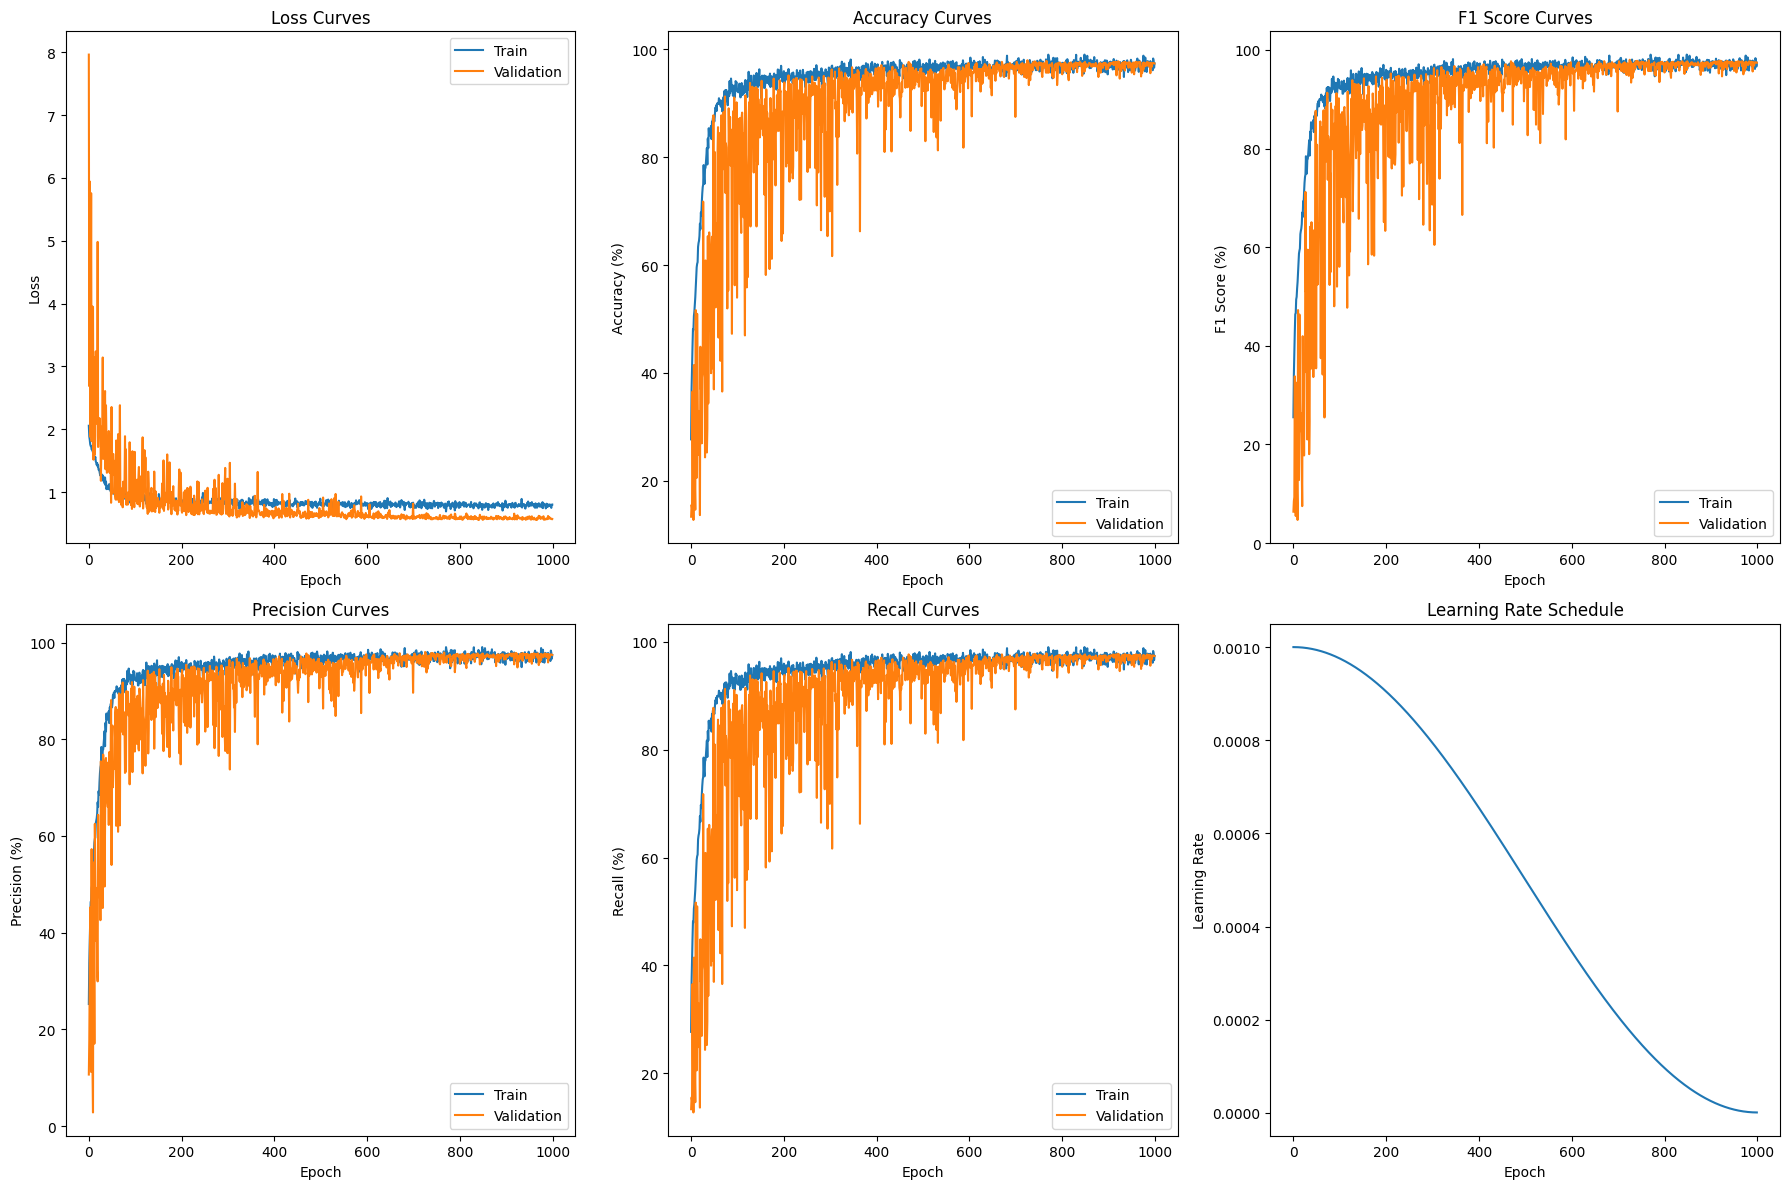

In [15]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loss plot
axes[0, 0].plot(training_history['train_loss'], label='Train')
axes[0, 0].plot(training_history['val_loss'], label='Validation')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Accuracy plot
axes[0, 1].plot(training_history['train_acc'], label='Train')
axes[0, 1].plot(training_history['val_acc'], label='Validation')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()

# F1 Score plot
axes[0, 2].plot(training_history['train_f1'], label='Train')
axes[0, 2].plot(training_history['val_f1'], label='Validation')
axes[0, 2].set_title('F1 Score Curves')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('F1 Score (%)')
axes[0, 2].legend()

# Precision plot
axes[1, 0].plot(training_history['train_prec'], label='Train')
axes[1, 0].plot(training_history['val_prec'], label='Validation')
axes[1, 0].set_title('Precision Curves')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision (%)')
axes[1, 0].legend()

# Recall plot
axes[1, 1].plot(training_history['train_rec'], label='Train')
axes[1, 1].plot(training_history['val_rec'], label='Validation')
axes[1, 1].set_title('Recall Curves')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall (%)')
axes[1, 1].legend()

# Learning rate plot
axes[1, 2].plot(training_history['lr'])
axes[1, 2].set_title('Learning Rate Schedule')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Learning Rate')

plt.tight_layout()
plt.savefig(os.path.join(config['checkpoint_dir'], 'training_history.png'))
plt.show()

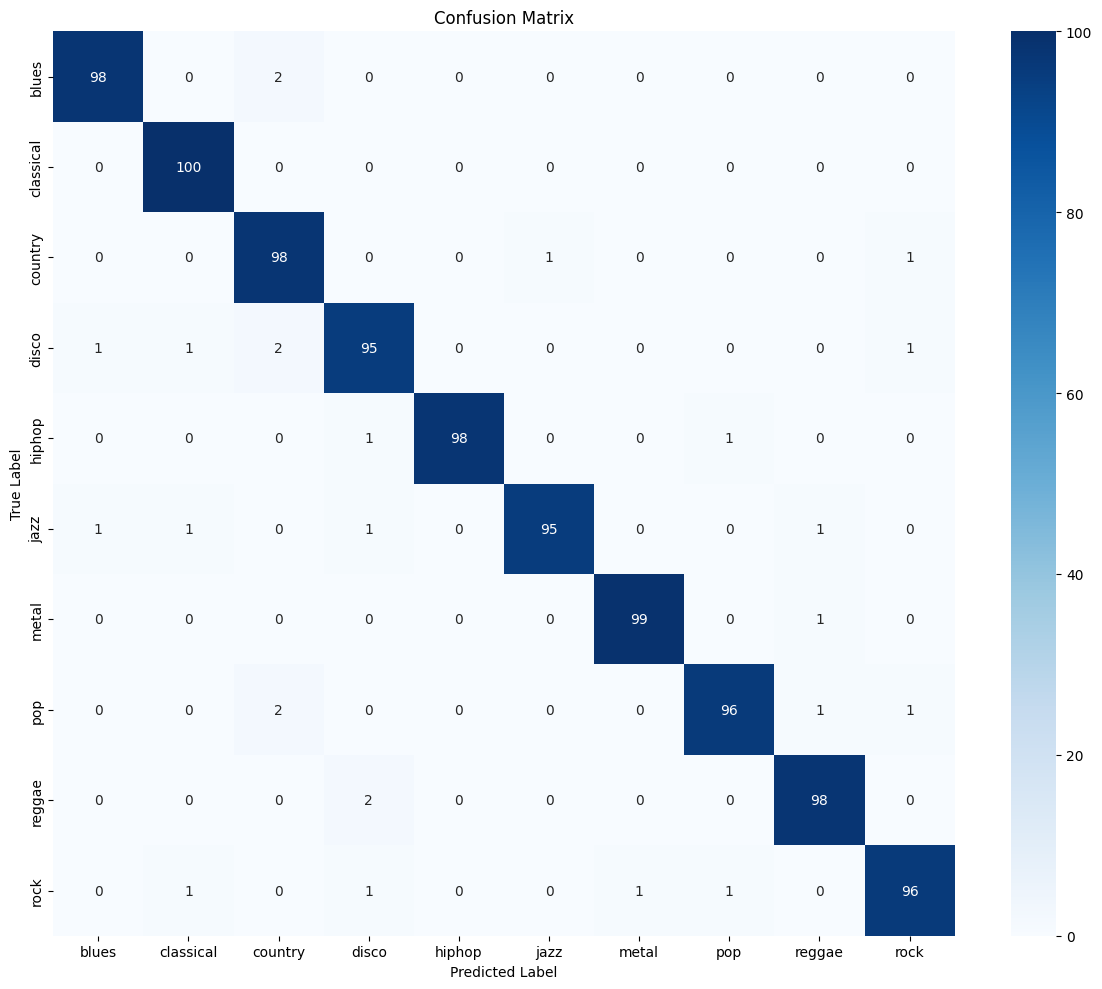

In [16]:
# Plot confusion matrix
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.numpy())

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(12, 10))
class_names = ["blues", "classical", "country", "disco", "hiphop", 
               "jazz", "metal", "pop", "reggae", "rock"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(config['checkpoint_dir'], 'confusion_matrix.png'))
plt.show()

In [17]:
test_metrics = validate(test_loader, model, criterion)
print(f"Test Metrics - Acc: {test_metrics['accuracy']:.2f}%, Precision: {test_metrics['precision']:.2f}%, "
      f"Recall: {test_metrics['recall']:.2f}%, F1: {test_metrics['f1_score']:.2f}%, Loss: {test_metrics['loss']:.4f}")

Test Metrics - Acc: 97.20%, Precision: 97.23%, Recall: 97.20%, F1: 97.20%, Loss: 0.5794
